In [1]:
import neo4j

host = "bolt://localhost"
username = "neo4j"
password = "1234qwer"

driver = neo4j.GraphDatabase.driver(f'{host}', auth=(username, password))

session = driver.session()

In [3]:
import psycopg2

pg_host = "localhost"
pg_database = "demo"
pg_user = "postgres"
pg_password = "postgres"

# Establish PostgreSQL connection
pg_conn = psycopg2.connect(
    host=pg_host,
    database=pg_database,
    user=pg_user,
    password=pg_password
)
pg_cursor = pg_conn.cursor()

In [11]:
session.run("""
MATCH (p:Requirement)
RETURN gds.graph.project(
  'BERTRequirementGraph',
  p,
  null,
  {
    sourceNodeProperties: p { .bert_embedding },
    targetNodeProperties: {}
  }
)
""")

In [13]:
records, summary, key = driver.execute_query("""
CALL gds.knn.stream('BERTRequirementGraph', {
    topK: 1,
    nodeProperties: {bert_embedding: 'EUCLIDEAN'},
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS id1, gds.util.asNode(node2).id AS id2, similarity
ORDER BY similarity DESC
""")

for row in records:
    insert_query = """
        INSERT INTO sentence_matching (source_id, target_id, similarity, method, embedding) 
        VALUES (%s, %s, %s, %s, %s)
    """
    pg_cursor.execute(insert_query, (row['id1'], row['id2'], row['similarity'], 'EUCLIDEAN', 'BERT'))
    pg_conn.commit()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def plot_score_distribution(scores, title):
    """
    Create a histogram with normal distribution curve for scores
    
    Parameters:
    scores (list): List of numerical scores
    """
    # Convert to numpy array if not already
    scores = np.array(scores)
    
    # Calculate mean and standard deviation
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Create the plot figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    counts, bins, _ = plt.hist(scores, bins=20, density=True, alpha=0.7, 
                              color='skyblue', label='Similarity Score Distribution')
    
    # Generate points for the normal distribution curve
    x = np.linspace(min(scores), max(scores), 100)
    pdf = stats.norm.pdf(x, mean, std)
    
    # Plot the normal distribution curve
    #plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
    
    # Add vertical line for mean
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean = {mean:.2f}')
    
    # Customize the plot
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

In [16]:
# Execute query to select similarities
pg_cursor.execute("""
    SELECT similarity 
    FROM result_graph 
    WHERE embedding = 'sBERT' 
    AND method = 'EUCLIDEAN'
""")

# Fetch all results
similarities = pg_cursor.fetchall()

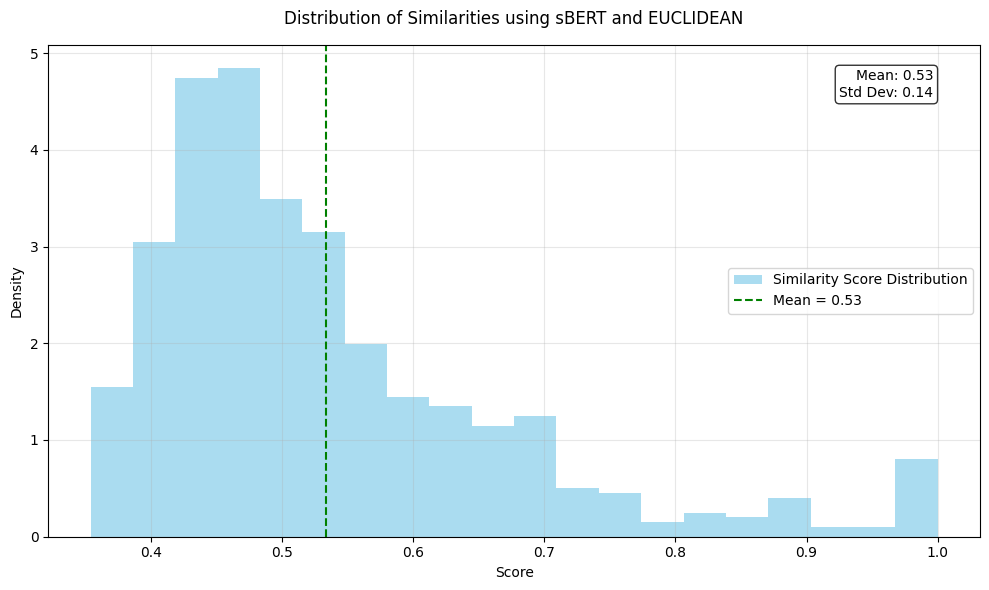

In [17]:
scores = similarities

# Create and display the plot
plot_score_distribution(scores, 'Distribution of Similarities using sBERT and EUCLIDEAN')
plt.show()

In [4]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def calculate_f1_score(method, embedding, threshold):
  # pg_cursor.execute(f"""
  # select 
	# coalesce(manual_labeling_matching.is_match, false) as label,
  #   (case when sentence_matching.similarity > {threshold} then true else false end) as predicted
  # from 
  #     distinct_pair
  # left join (
  #       select * from result_graph 
  #       where "method" = '{method}' and embedding = '{embedding}'
  # ) as sentence_matching on (
  #   (distinct_pair.id1 = sentence_matching.source_id and distinct_pair.id2 = sentence_matching.target_id) or 
  #   (distinct_pair.id1 = sentence_matching.target_id and distinct_pair.id2 = sentence_matching.source_id)
  # )
  # left join prompt_matching as manual_labeling_matching on (
  #   (distinct_pair.id1 = manual_labeling_matching.source_id and distinct_pair.id2 = manual_labeling_matching.target_id) or 
  #   (distinct_pair.id1 = manual_labeling_matching.target_id and distinct_pair.id2 = manual_labeling_matching.source_id)
  # )
  # """)
  pg_cursor.execute(f"""
  with result_cte as (
    select * from result_graph 
      where "method" = '{method}' and embedding = '{embedding}'
  )
select 
	coalesce(manual_labeling_matching.is_match, false) as label,
    (case when result_cte.similarity > {threshold} then true else false end) as predicted
  from 
      result_cte
  left join prompt_matching as manual_labeling_matching on (
    (result_cte.source_id = manual_labeling_matching.source_id and result_cte.target_id = manual_labeling_matching.target_id) or 
    (result_cte.source_id = manual_labeling_matching.target_id and result_cte.target_id = manual_labeling_matching.source_id)
  )
""")
  data_predict = pg_cursor.fetchall()
  label = []
  predicted = []
  for data in data_predict:
      label.append(data[0])
      predicted.append(data[1])
  accuracy = accuracy_score(label, predicted)
  recall = recall_score(label, predicted)
  precision = precision_score(label, predicted)
  f1 = f1_score(label, predicted)
  print(f'{threshold:.2f},{accuracy:.3f},{recall:.3f},{precision:.3f},{f1:.3f}')
  return accuracy, f1, recall, precision

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_conffussion_matrix(method, embedding, threshold):
  #   pg_cursor.execute(f"""
  #   select 
	# coalesce(manual_labeling_matching.is_match, false) as label,
  #   (case when sentence_matching.similarity > {threshold} then true else false end) as predicted
  # from 
  #     distinct_pair
  # left join (
  #       select * from result_graph 
  #       where "method" = '{method}' and embedding = '{embedding}'
  # ) as sentence_matching on (
  #   (distinct_pair.id1 = sentence_matching.source_id and distinct_pair.id2 = sentence_matching.target_id) or 
  #   (distinct_pair.id1 = sentence_matching.target_id and distinct_pair.id2 = sentence_matching.source_id)
  # )
  # left join prompt_matching as manual_labeling_matching on (
  #   (distinct_pair.id1 = manual_labeling_matching.source_id and distinct_pair.id2 = manual_labeling_matching.target_id) or 
  #   (distinct_pair.id1 = manual_labeling_matching.target_id and distinct_pair.id2 = manual_labeling_matching.source_id)
  # )
  #   """)
    pg_cursor.execute(f"""
  with result_cte as (
    select * from result_graph 
      where "method" = '{method}' and embedding = '{embedding}'
  )
select 
	coalesce(manual_labeling_matching.is_match, false) as label,
    (case when result_cte.similarity > {threshold} then true else false end) as predicted
  from 
      result_cte
  left join prompt_matching as manual_labeling_matching on (
    (result_cte.source_id = manual_labeling_matching.source_id and result_cte.target_id = manual_labeling_matching.target_id) or 
    (result_cte.source_id = manual_labeling_matching.target_id and result_cte.target_id = manual_labeling_matching.source_id)
  )
""")
    data_predict = pg_cursor.fetchall()
    label = []
    predicted = []
    for data in data_predict:
        label.append(data[0])
        predicted.append(data[1])

    cm = confusion_matrix(y_true=label, y_pred=predicted, labels=[0, 1])
    # Create figure and axes
    plt.figure(figsize=(8, 6))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels
    plt.title(f"Confusion Matrix {embedding} graph-base")

    # Show plot
    plt.show()

In [25]:
thresholds = np.arange(0.6, 0.7, 0.01)
accuracy_scores = []
f1_scores = []

# Execute queries and collect accuracy scores
for threshold in thresholds:
    accuracy, f1, recall, precision = calculate_f1_score('COSINE', 'sBERT', threshold)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print(f'{threshold:.2f},{accuracy:.3f},{recall:.2f},{precision:.2f},{f1:.3f}')

0.60,0.992,0.234,0.251,0.242
0.60,0.992,0.23,0.25,0.242
0.61,0.992,0.234,0.251,0.242
0.61,0.992,0.23,0.25,0.242
0.62,0.992,0.234,0.252,0.243
0.62,0.992,0.23,0.25,0.243
0.63,0.992,0.234,0.252,0.243
0.63,0.992,0.23,0.25,0.243
0.64,0.992,0.234,0.255,0.244
0.64,0.992,0.23,0.25,0.244
0.65,0.992,0.234,0.256,0.244
0.65,0.992,0.23,0.26,0.244
0.66,0.992,0.233,0.256,0.244
0.66,0.992,0.23,0.26,0.244
0.67,0.992,0.233,0.256,0.244
0.67,0.992,0.23,0.26,0.244
0.68,0.992,0.233,0.259,0.245
0.68,0.992,0.23,0.26,0.245
0.69,0.993,0.232,0.259,0.245
0.69,0.993,0.23,0.26,0.245


In [8]:
print('COSINE', 'text-embedding-ada-002')
calculate_f1_score('COSINE', 'text-embedding-ada-002', 0.77)
print('EUCLIDEAN', 'text-embedding-ada-002')
calculate_f1_score('EUCLIDEAN', 'text-embedding-ada-002', 0.51)
print('COSINE', 'BERT')
calculate_f1_score('COSINE', 'BERT', 0.77)
print('EUCLIDEAN', 'BERT')
calculate_f1_score('EUCLIDEAN', 'BERT', 0.51)
print('COSINE', 'sBERT')
calculate_f1_score('COSINE', 'sBERT', 0.77)
print('EUCLIDEAN', 'sBERT')
calculate_f1_score('EUCLIDEAN', 'sBERT', 0.51)

COSINE text-embedding-ada-002
0.77,0.369,0.936,0.314,0.471
EUCLIDEAN text-embedding-ada-002
0.51,0.557,0.675,0.347,0.458
COSINE BERT
0.77,0.349,0.915,0.296,0.448
EUCLIDEAN BERT
0.51,0.563,0.587,0.342,0.433
COSINE sBERT
0.77,0.361,0.912,0.272,0.419
EUCLIDEAN sBERT
0.51,0.557,0.576,0.349,0.435


(0.5565843621399177,
 0.4351245085190039,
 0.5763888888888888,
 0.3494736842105263)

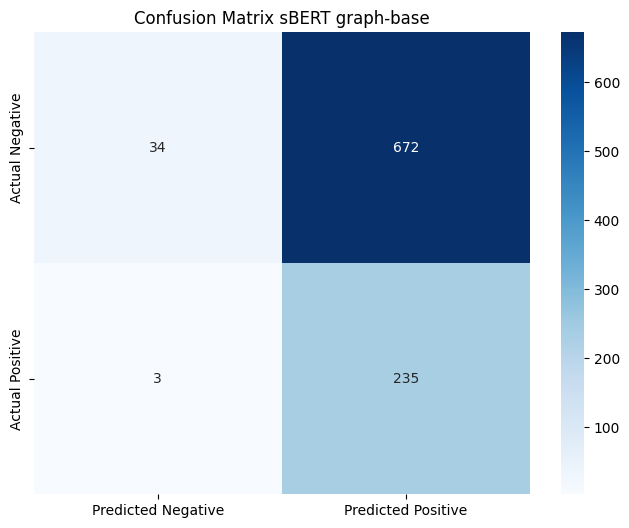

In [7]:
draw_conffussion_matrix('COSINE', 'sBERT', 0.68)